In [1]:
import tensorflow.keras as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import cv2
import os
from google.colab import drive
import seaborn as sns

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
classes = 2
dataset_path = "/content/drive/My Drive/Dataset"

labels = {
    'Brawl' : 0,
    'Peace' : 1
}

def load_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    middle_frame_idx = total_frames // 2

    cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame_idx)
    success, frame = cap.read()
    cap.release()

    if not success:
        return None

    frame = cv2.resize(frame, (170,170))
    return frame.astype("float32") / 255.0

def load_dataset(dataset_path, labels):
    X, y = [], []
    for label, idx in labels.items():
        folder_path = os.path.join(dataset_path, label)

        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} not found.")
            continue

        for video_file in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video_file)
            frame = load_frame(video_path)

            if frame is not None:
                X.append(frame)
                y.append(idx)

    X = np.array(X)
    y = to_categorical(y, classes)

    return X, y

X,y = load_dataset(dataset_path,labels)

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,test_size = 0.2,random_state = 42)

In [4]:
def build_2DCNN():
  model = Sequential([
      Conv2D(filters=96,kernel_size=(11,11),strides=(3,3),padding="same",activation="relu",input_shape=(170,170,3)),
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(filters=256,kernel_size=(5,5),padding="same",activation="relu"),
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(filters=384,kernel_size=(3,3),padding="same",activation="relu"),
      Conv2D(filters=384,kernel_size=(3,3),padding="same",activation="relu"),
      Conv2D(filters=256,kernel_size=(3,3),padding="same",activation="relu"),
      MaxPooling2D(pool_size=(2,2)),
      Flatten(),
      Dense(4096,activation="relu"),
      Dropout(0.5),
      Dense(4096,activation="relu"),
      Dropout(0.5),
      Dense(classes,activation="softmax")
  ])
  return model

In [5]:
model = build_2DCNN()
model.compile(
    optimizer = Adam(learning_rate = 0.00001),
    loss = ['categorical_crossentropy'],
    metrics = ['accuracy']
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 57, 57, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 28, 28, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      51,384,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           8,194 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,921,026 (274.36 MB)

 Trainable params: 71,921,026 (274.36 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(
    X_train,y_train,
    epochs = 20,
    validation_data = (X_test,y_test)
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - accuracy: 0.5068 - loss: 0.6929 - val_accuracy: 0.5469 - val_loss: 0.6905
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.5525 - loss: 0.6875 - val_accuracy: 0.4875 - val_loss: 0.6912
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6048 - loss: 0.6809 - val_accuracy: 0.6313 - val_loss: 0.6736
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.5841 - loss: 0.6743 - val_accuracy: 0.6000 - val_loss: 0.6685
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.6489 - loss: 0.6531 - val_accuracy: 0.6938 - val_loss: 0.6237
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6699 - loss: 0.6307 - val_accuracy: 0.6594 - val_loss: 0.6129
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6646 - loss: 0.6184 - val_accuracy: 0.6562 - val_loss: 0.6208
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.6914 - loss: 0.5822 - val_accuracy: 0.5656 -

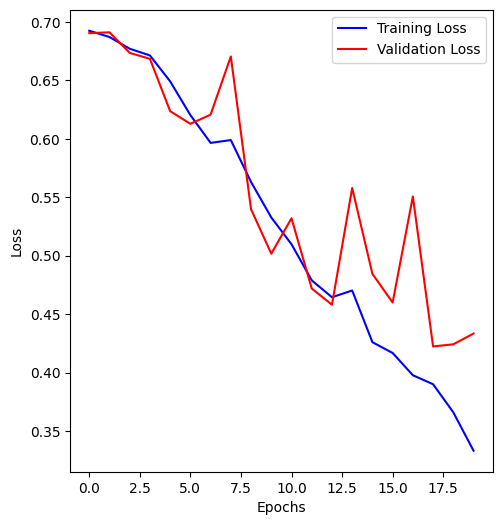

In [7]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(train_loss,label = "Training Loss",color = "blue")
plt.plot(val_loss,label = "Validation Loss",color = "red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

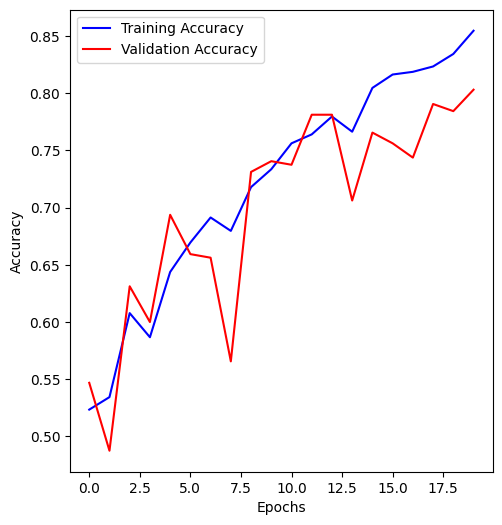

In [8]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(train_accuracy,label = "Training Accuracy",color = "blue")
plt.plot(val_accuracy,label = "Validation Accuracy",color = "red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


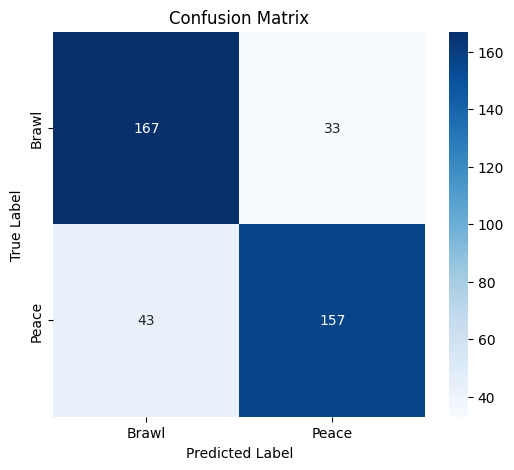

In [9]:
path = "/content/drive/My Drive/Test"
X_testing,y_testing = load_dataset(path,labels)

y_pred = model.predict(X_testing)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_testing, axis=1)

cm = confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [10]:
true_positive = cm[0,0]
false_positive = cm[0,1]
false_negative = cm[1,0]
true_negative = cm[1,1]

precision = true_positive/(true_positive+false_positive)
recall = true_positive/(true_positive+false_negative)
f1score = (2 * precision * recall) / (precision + recall)

print(f"The model has a precision of {precision:.5f}, recall of {recall:.5f} and F1 Score of {f1score:.5f}")

The model has a precision of 0.83500, recall of 0.79524 and F1 Score of 0.81463


In [11]:
model.save("breaking-bias-2014-dropout-half.h5")